<a href="https://colab.research.google.com/github/ToffertheCreator/colab_notebooks/blob/main/Tuberculosis_classification_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import json
from zipfile import ZipFile
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

In [ ]:
!pip install opendatasets --upgrade

In [ ]:
import opendatasets as od
dataset_url = 'https://www.kaggle.com/datasets/tawsifurrahman/tuberculosis-tb-chest-xray-dataset'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: letmeiiin1234556789
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/tuberculosis-tb-chest-xray-dataset


100%|██████████| 663M/663M [00:02<00:00, 252MB/s]


In [ ]:
import os
import shutil

base_dir = '/content/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database'

# Define the unwanted class
unwanted_class = '.ipynb_checkpoints'

# Full path to the unwanted class folder
unwanted_class_path = os.path.join(base_dir, unwanted_class)

# Remove the folder if it exists
if os.path.exists(unwanted_class_path):
    shutil.rmtree(unwanted_class_path)

# Verify remaining classes
classes = os.listdir(base_dir)
print(classes)

['Tuberculosis', 'Normal']


(512, 512)


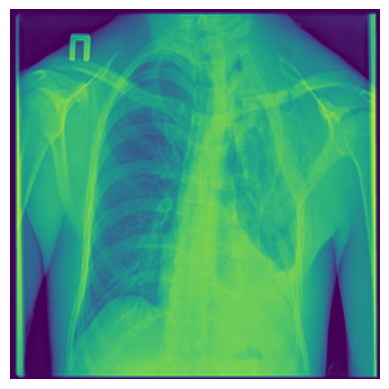

In [ ]:
image_path = '/content/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Tuberculosis/Tuberculosis-108.png'
# Read the image
img = mpimg.imread(image_path)

print(img.shape)
# Display the image
plt.imshow(img)
plt.axis('off')  # Turn off axis numbers
plt.show()

In [ ]:
# Image Parameters
img_size = 224
batch_size = 32

In [ ]:
# Image Data Generators
data_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Use 20% of data for validation
)

In [ ]:
# Train Generator
train_generator = data_gen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    subset='training',
    class_mode='binary',
)


Found 3360 images belonging to 2 classes.


In [ ]:
# Validation Generator
validation_generator = data_gen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    subset='validation',
    class_mode='binary',
)

Found 840 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

# Set the image size
img_size = 224

# Load the ResNet50 model, excluding the top (fully connected) layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Freeze the base model's layers to avoid updating them during training
base_model.trainable = False

# Create a new model and add the ResNet base
model = models.Sequential()
model.add(base_model)

# Add your custom fully connected layers on top of ResNet
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))  # Assuming binary classification

# Unfreeze some layers for fine-tuning
for layer in base_model.layers[-40:]:  # Unfreeze the last 40 layers, for example
    layer.trainable = True


In [ ]:
# model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_2 (Dense)             (None, 256)               25690368  
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 49278337 (187.98 MB)
Trainable params: 25690625 (98.00 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [ ]:
# Compile and train your model
model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(train_generator, epochs=10, validation_data=validation_generator)

Epoch 1/10
105/105 [==============================] - 83s 759ms/step - loss: 2.1690 - accuracy: 0.8780 - val_loss: 0.8738 - val_accuracy: 0.1667
Epoch 2/10
105/105 [==============================] - 79s 752ms/step - loss: 0.1764 - accuracy: 0.9301 - val_loss: 0.3822 - val_accuracy: 0.8976
Epoch 3/10
105/105 [==============================] - 79s 750ms/step - loss: 0.1474 - accuracy: 0.9446 - val_loss: 0.2172 - val_accuracy: 0.9083
Epoch 4/10
105/105 [==============================] - 78s 741ms/step - loss: 0.1373 - accuracy: 0.9452 - val_loss: 0.1628 - val_accuracy: 0.9262
Epoch 5/10
105/105 [==============================] - 79s 754ms/step - loss: 0.1255 - accuracy: 0.9411 - val_loss: 0.1398 - val_accuracy: 0.9357
Epoch 6/10
105/105 [==============================] - 81s 768ms/step - loss: 0.1340 - accuracy: 0.9387 - val_loss: 0.1216 - val_accuracy: 0.9440
Epoch 7/10
105/105 [==============================] - 81s 774ms/step - loss: 0.1214 - accuracy: 0.9521 - val_loss: 0.0874 - val_ac

In [ ]:
# Model Evaluation
print("Evaluating model...")
val_loss, val_accuracy = model.evaluate(validation_generator, steps=validation_generator.samples // batch_size)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

Evaluating model...
26/26 [==============================] - 14s 521ms/step - loss: 0.1346 - accuracy: 0.9579
Validation Accuracy: 95.79%


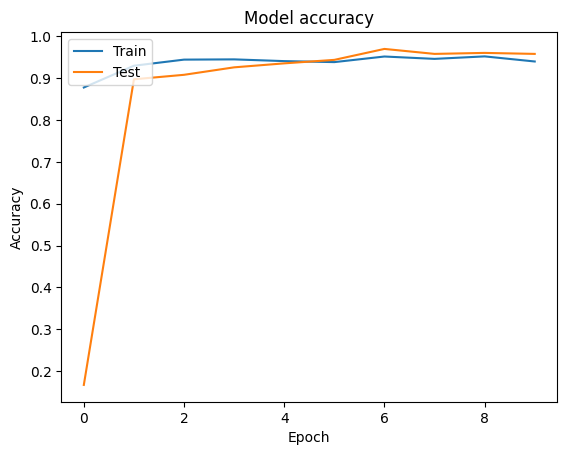

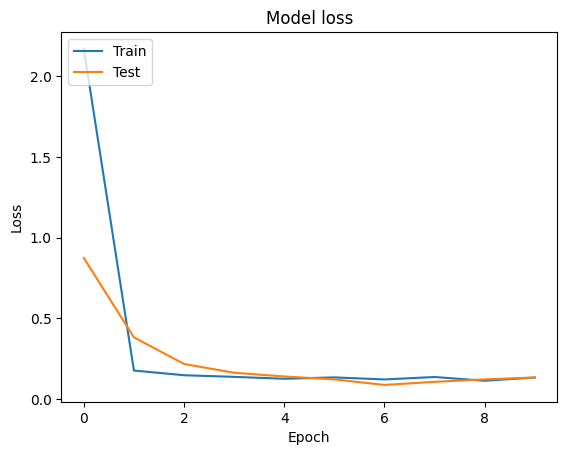

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# Function to Load and Preprocess the Image using Pillow
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    # Load the image in RGB mode
    img = Image.open(image_path).convert('RGB')
    # Resize the image
    img = img.resize(target_size)
    # Convert the image to a numpy array
    img_array = np.array(img)
    # Add batch dimension
    img_array = np.expand_dims(img_array, axis=0)
    # Scale the image values to [0, 1]
    img_array = img_array.astype('float32') / 255.
    return img_array



# Function to Predict the Class of an Image
def predict_image_class(model, image_path, class_indices):
    preprocessed_img = load_and_preprocess_image(image_path)
    predictions = model.predict(preprocessed_img)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class_name = class_indices[predicted_class_index]
    return predicted_class_name

In [ ]:
# Create a mapping from class indices to class names
class_indices = {v: k for k, v in train_generator.class_indices.items()}

In [ ]:
class_indices

{0: 'Normal', 1: 'Tuberculosis'}

In [ ]:
# saving the class names as json file
json.dump(class_indices, open('class_indices.json', 'w'))

In [ ]:
image_path = '/content/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Normal/Normal-1002.png'
predicted_class_name = predict_image_class(model, image_path, class_indices)

# Output the result
print("Predicted Class Name:", predicted_class_name)

1/1 [==============================] - 0s 92ms/step
Predicted Class Name: Normal


In [ ]:
model.save('plant_disease_prediction_model.keras')